# Диффузионные модели

[[arxiv] 🎓 Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/abs/2006.11239)

В GAN мы преобразовывали шум в целевой объект в один шаг с использованием сложной функции — генератора, и задача обучения GAN состояла в обучении этой функции.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/gan_transform_idea.png" width="350"></center>

Идея диффузии состоит в том, чтобы делать это не за один шаг, а за много маленьких шагов.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/diffusion_process.png" width="1000"></center>

## Базовые понятия библиотеки Diffusers


Для работы с диффузионными моделями мы будем использовать библиотеку Diffusers от Hugging Face. С вариантом кода на чистом PyTorch вы можете ознакомиться в [отдельном блокноте 🥨 [colab]](https://colab.research.google.com/github/Gan4x4/cv/blob/main/Generative_models/handmade_diffusion.ipynb).

Diffusers — это библиотека, целью которой является сделать диффузионные модели широко доступными для всех.

Перед началом работы необходимо установить библиотеки [Diffusers 🛠️[doc]](https://huggingface.co/docs/diffusers/index), [Accelerate 🛠️[doc]](https://huggingface.co/docs/accelerate/quicktour) и [Transformers 🛠️[doc]](https://huggingface.co/docs/transformers/index).

* Accelerate — это вспомогательная библиотека, которая позволяет запускать PyTorch-код с различными конфигурациями оборудования (несколько GPU, TPU и т. д.) без дополнительной адаптации кода. Библиотека Diffusers использует библиотеку Accelerate. Это важно для диффузионных моделей, т. к. они обычно тяжелые и требуют большого количества ресурсов.

* Transformers — необходима для запуска популярных text-to-image диффузионных моделей, таких как [Stable Diffusion 🛠️[doc]](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/overview).

In [1]:
import locale
from IPython.display import clear_output

locale.getpreferredencoding = lambda: "UTF-8"

!pip install -q accelerate
!pip install -q diffusers
!pip install -q transformers

clear_output()

## Прямой диффузионный процесс (добавление шума)

Пусть мы имеем некоторый объект $\mathbf{x}_0$ из заданного имеющимся датасетом распределения $\mathbf{x}_0 \sim q(\mathbf{x})$. Определим так называемый прямой диффузионный процесс, в ходе которого мы будем последовательно добавлять небольшое количество Гауссового шума последовательно $T$ раз, создавая из нашего объекта последовательность $\mathbf{x}_1, \dots, \mathbf{x}_T$ постепенно всё более зашумленных версий нашего исходного объекта:

$$\large \mathbf{x_t} = \sqrt{1-\beta_t}\mathbf{x_{t-1}}+\sqrt{\beta_t}\mathbf{n_{t-1}},$$

где $\mathbf{n_{t-1}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, а $\beta_t$ — дисперсия добавляемого на $t$-ом шаге шума.

Параметры добавляемого шума зависят от номера шага зашумления. Набор $\{\beta_t \in (0, 1)\}_{t=1}^T$ именуется планировщиком зашумления и задается заранее. В конце зашумления получаем нормальный шум: $\mathbf{x_T} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

Посмотрим, как это будет выглядеть на различных изображениях:

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/denoising_diffusion_example.jpg" width="1000"></center>

<center><em>Прямой диффузионный процесс, T=1000</em></center>

<center><em>Source: <a href="https://learnopencv.com/denoising-diffusion-probabilistic-models/">An In-Depth Guide to Denoising Diffusion Probabilistic Models – From Theory to Implementation</a></em></center>

Исходное распределение данных из датасета будет последовательно преобразовано в Гауссов шум:

$$ \large
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$$

$$\large q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad$$




### Причина использования Гауссова шума

Важным свойством Гауссова распределения является то, что оно допускает аналитическое вычисление параметров шума на любом из шагов процесса в явном виде. Это связано с тем, что сумма нескольких нормально распределенных случайных величин также является случайной величиной с нормальным распределением. Это значит, что **во время обучения модели для подготовки данных нам не нужно будет делать до $T$ шагов зашумления**.

Для этого удобно ввести обозначение $\large \alpha_t = 1 - \beta_t$. Тогда один шаг прямого диффузионного процесса будет выражаться так:

$$ \large \mathbf{x}_t= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\mathbf{n}_{t-1}$$

Можно показать, что для $\large t$-го шага прямого диффузионного процесса зашумленное изображение $\large \mathbf{x}_t$ выражается через исходное изображение $\large \mathbf{x}_0$ следующим образом:

$$ \large \mathbf{x}_t = \sqrt{\overline{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \overline{\alpha}_t}\bar{\mathbf{n}}_{0}, $$

где $\large \bar{\alpha}_t = \prod_{s=1}^t \alpha_s$, а  $\large \bar{\mathbf{n}}_{0} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

На практике можно использовать другие методы зашумления/деградации изображения, которые больше подходят под ваши данные.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/diffusion_models_results.png" width="1000"></center>
<center><em>Результат работы диффузионных моделей, использующих различные типы деградации/зашумления изображения</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2208.09392.pdf">Cold Diffusion: Inverting Arbitrary Image Transforms Without Noise</a></em></center>

### Зашумление в библиотеке Diffusers

Одной из ключевых частей библиотеки Diffusers является планировщик (Scheduler). Он отвечает за прямой диффузионный процесс (добавление шума) и за вычитание шума при генерации (в ходе обратного диффузионного процесса). Мы рассмотрим `DDPMScheduler`, т. к. в нем реализован алгоритм из [базовой статьи 🎓[arxiv]
](https://arxiv.org/abs/2006.11239).

In [2]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(num_train_timesteps=1000)

Посмотрим на параметры планировщика:

In [3]:
scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.33.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

В параметры входят:

- `num_train_timesteps` — количество временных шагов, необходимое для преобразования случайного гауссовского шума в изображение;
- `beta_schedule` — тип планировщика зашумления;
- `beta_start` и `beta_end` — начальное и конечное значения коэффициента $β_t$.

Посмотрим, как зашумляется изображение. Продолжим эксперименты с FashionMNIST.

In [4]:
import os
import torch
from torchvision import datasets
from torchvision.transforms import v2

os.makedirs("../../data/mnist", exist_ok=True)

data_set = datasets.FashionMNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.5], [0.5]),
        ]
    ),
)

clear_output()

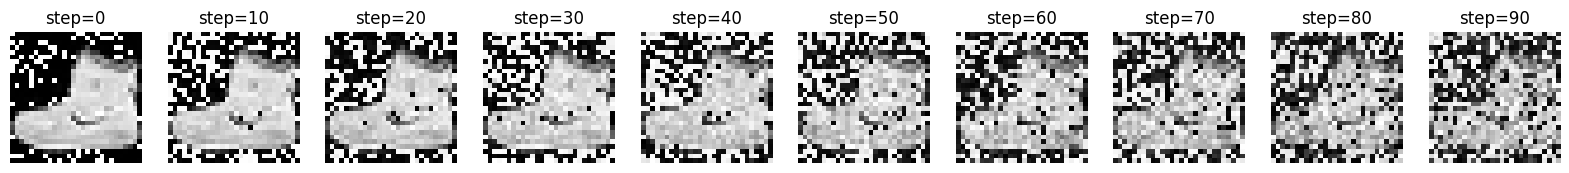

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt


sample_image = data_set[0][0].unsqueeze(0)


def display_sample(sample, t, ax, title="step="):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)
    ax.imshow(image_processed[0], cmap=plt.get_cmap("gray"))
    ax.axis("off")
    ax.set_title(title + str(t))


fig, axs = plt.subplots(ncols=10, nrows=1, figsize=(20, 4))

for i, t in enumerate(range(0, 100, 10)):
    noise = torch.randn(sample_image.shape)
    timesteps = torch.LongTensor([t])
    noisy_image = scheduler.add_noise(sample_image, noise, timesteps)
    display_sample(noisy_image, t, axs[i])

### Планировщик зашумления

В [оригинальной статье 🎓[arxiv]](https://arxiv.org/pdf/2006.11239.pdf) используется линейный планировщик зашумления, который реализованный внутри [планировщика 🛠️[doc]](https://huggingface.co/docs/diffusers/main/en/api/schedulers/overview) `DDPMScheduler`.

In [6]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

Посмотрим, как меняются $β$ и $\overline{\alpha}_t$:


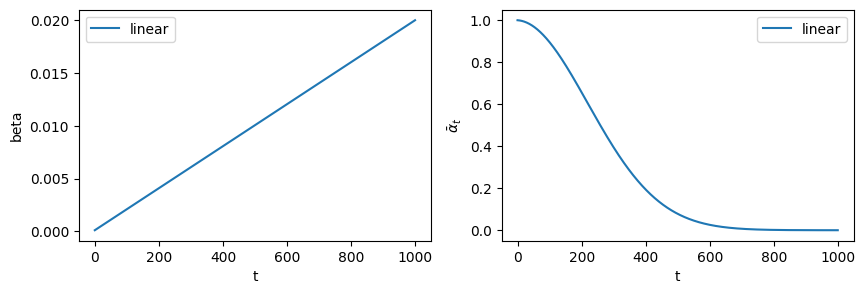

In [7]:
beta_linear = noise_scheduler.betas
alpha_linear = noise_scheduler.alphas
alpha_hat_linear = noise_scheduler.alphas_cumprod

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(beta_linear, label="linear")
axs[0].set_xlabel("t")
axs[0].set_ylabel("beta")
axs[0].legend()

axs[1].plot(alpha_hat_linear, label="linear")
axs[1].set_xlabel("t")
axs[1].set_ylabel(r"$\bar{\alpha}_t$")
axs[1].legend()

plt.show()

$\overline{\alpha}_t$ меняется сильно нелинейно. В [более поздней статье 🎓[arxiv]](https://arxiv.org/pdf/2102.09672.pdf) предложен косинусный планировщик зашумления:

In [8]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

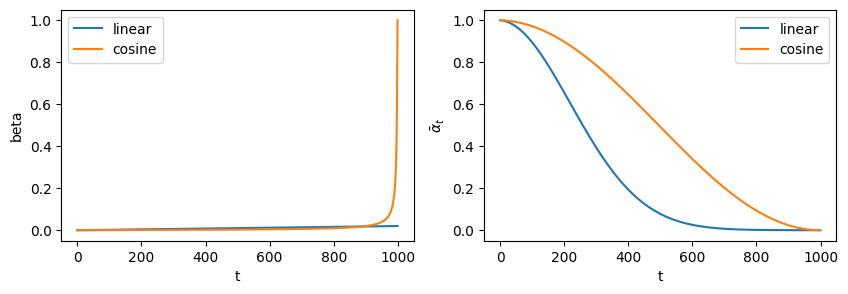

In [9]:
beta_cosine = noise_scheduler.betas
alpha_cosine = noise_scheduler.alphas
alpha_hat_cosine = noise_scheduler.alphas_cumprod

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(beta_linear, label="linear")
axs[0].plot(beta_cosine, label="cosine")
axs[0].set_xlabel("t")
axs[0].set_ylabel("beta")
axs[0].legend()

axs[1].plot(alpha_hat_linear, label="linear")
axs[1].plot(alpha_hat_cosine, label="cosine")
axs[1].set_xlabel("t")
axs[1].set_ylabel(r"$\bar{\alpha}_t$")
axs[1].legend()

plt.show()

Изменение $\overline{\alpha}_t$ для косинусного планировщика более линейно.
В [статье 🎓[arxiv]](https://arxiv.org/pdf/2102.09672.pdf) показано, что такая форма минимизирует Negative Log-Likelihood, что приводит к улучшению качества изображения. Визуально зашумление изображения с использованием косинусного планировщика кажется более равномерным:



<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/linear_cosine_schedules.png" width="950"></center>

<center><em>Результат работы линейного (верх) и косинусного (низ) планировщиков зашумления</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2102.09672.pdf">Improved Denoising Diffusion Probabilistic Models</a></em></center>

## Обратный диффузионный процесс (удаление шума)

$$\large p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod^T_{t=1} p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) \quad
p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$$

Целью обратного диффузионного процесса является “расшумление” изображения. Для осуществления данного процесса используется нейросеть, архитектуру которой мы рассмотрим ниже. Пока нам нужно определиться с входом и выходом сети и функцией ошибок:
- На вход модели поступают зашумленное изображение $\mathbf{x}_t = \sqrt{\overline{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \overline{\alpha}_t}\bar{\mathbf{n}}_{0} $
и текущий шаг $t$. Модель пытается предсказать **весь добавленный шум** $\bar{\mathbf{n}}_{0}$ (так она работает более устойчиво).
- На выходе предсказываемый моделью шум $\bar{\mathbf{n}}_{0} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. Мы не изменяем дисперсию предсказываемого шума от номера шага — он всегда в одном диапазоне.
- В качестве функции ошибок используется MSE:

$$\large \text{Loss} = \text{MSE}(\bar{\mathbf{n}}_{0}, \mathbf{n}_θ(x_t, t)).$$

- В одном батче на обучение присутствуют разные картинки $\mathbf{x}$ на разных стадиях зашумления $t$.

Подробное математическое обоснование:
* [[arxiv] 🎓 Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/pdf/2006.11239.pdf)
* [[blog] ✏️ What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models)

### Denoising U-Net

Архитектура  Denoising U-Net представлена на картинке ниже. Это уже знакомый нам из лекции по сегментации U-Net с привычными skip connections между картами признаков энкодера и декодера (рыжие стрелки и надпись concatenate). На входе сети — зашумленное изображение, на выходе — предсказанный шум.

В качестве базового блока используются ResNet блоки. Из архитектурных добавлений:
- блоки Self-Attention,
- примешивание эмбеддинга текущего шага генерации $t$ при каждом изменении размера.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/denoising_unet_architecture.png" width="800"></center>

<center><em>Архитектура Denoising U-Net</em></center>

<center><em>Source: <a href="https://learnopencv.com/denoising-diffusion-probabilistic-models/">
An In-Depth Guide to Denoising Diffusion Probabilistic Models – From Theory to Implementation</a></em></center>

Загрузить предобученную модель можно в бибилиотеке Diffusers с помощью метода `from_pretrained`. Загрузим базовую модель безусловной генерации изображений, обученную на изображениях кошек:

In [10]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-cat-256"
model = UNet2DModel.from_pretrained(repo_id, use_safetensors=True)
clear_output()

Посмотрим на параметры модели:

In [11]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('time_embedding_dim', None),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2D'),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
   

Конфигурация модели представляет собой `FrozenDict`. Это значит, что параметры нельзя изменить после создания модели. В параметры модели входят:

- `sample_size` — высота и ширина изображения, тут 256×256;
- `in_channels`, `out_channels` — количество каналов изображения, тут 3;
- `down_block_types` и `up_block_types` — тип блоков понижения и повышения размерности, используемых для создания архитектуры U-Net (в данном случае у нас только по одному блоку с Attention ближе к середине U-Net);
- `block_out_channels` — количество выходных каналов блоков понижения размерности, используется в обратном порядке для количества входных каналов блоков повышения размерности;
- `layers_per_block` — количество блоков ResNet, присутствующих в каждом блоке U-Net.

Есть модификации, которые предсказывают предыдущую выборку или [v-prediction 🎓[article]](https://imagen.research.google/video/paper.pdf). Тип предсказания можно посмотреть в атрибуте `prediction_type` у планировщиков (`epsilon` — предсказание остаточного шума, `sample` — предсказание предыдущей выборки или `v_prediction`).

Можно распечатать архитектуру модели:

In [12]:
print(model)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

Альтернативой U-Net являются [трансформерные модели 🎓[article]](https://huggingface.co/papers/2212.09748).

#### Базовый блок

В качестве базового блока используются ResNet блоки с SiLU в качестве функции активации и GroupNorm.

In [13]:
print(model.down_blocks[0].resnets[0])

ResnetBlock2D(
  (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
  (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nonlinearity): SiLU()
)


#### Понижение и повышение размерности

При повышении и понижении размерности к картам признаков примешивается информация о текущем шаге зашумления/расшумления. Это делается через “аппендикс” c линейным слоем, который изменяет размер эмбеддинга до количества каналов карты признаков $C_{out}$ и суммирует эмбеддинг с каналами.

Понижение размерности:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/down_block.png" width="700"></center>

Повышение размерности — не забываем про skip connection:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/upblock.png" width="900"></center>

В качестве позиционного эмбеддинга используется sin-cos позиционный эмбеддинг из трансформеров.

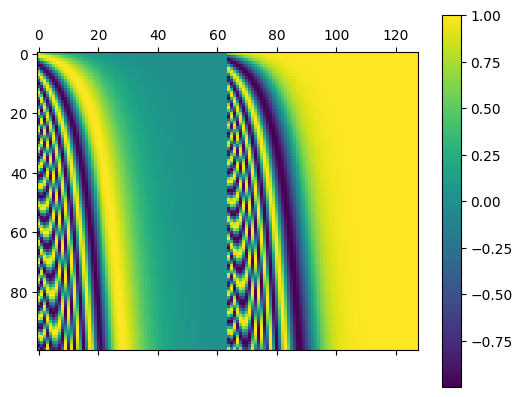

In [14]:
num_noise_steps = 1000

t = torch.arange(start=1, end=1000, step=1)
positional_embeding = model.time_proj(t)
embeding_img = positional_embeding.numpy()

cax = plt.matshow(embeding_img[0:100])
plt.gcf().colorbar(cax)
plt.show()

#### Self-Attention

Стоит обратить внимание на то, что блок Self-Attention применяется к изображению попиксельно. Именно для этого карты признаков с размерами H×W вытягиваются в векторы HW. Это связано с тем, что пиксели шума, добавляемого к изображению, не коррелированны. Self-Attention — самая вычислительно тяжелая часть модели.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/se_block.png" width="900"></center>

### Процесс генерации

Процесс генерации происходит по следующему алгоритму:
1. В начале семплируется $\mathbf{x_T} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.
2. В цикле по $t = T, ..., 1$:

 3. Если $t>1$, семплируется $\bar{\mathbf{n}}_{t-1} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, иначе $\bar{\mathbf{n}}_{t-1}= \mathbf{0}$

 4. С помощью модели предсказывается $ \mathbf{n}_θ(x_t, t)$.

 5. Вычисляется "расшумленная на один шаг" версия изображения:
$$\large \mathbf{x}_{t-1} = \dfrac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \dfrac{1 - \alpha_t}{\sqrt{1 - \overline{\alpha}_t}} \mathbf{n}_θ(x_t, t)\right) + \sqrt{\beta_t}\bar{\mathbf{n}}_{t-1}$$

    
6. На выходе из цикла имеем полностью "расшумленное" изображение $\large \mathbf{x}_0$.



Внутри шага 5 реализуется следующая идея: сначала из изображения на шаге $t$ вычитается весь предсказанный на этом шаге шум (выражение внутри скобок), а затем к результату добавляется следующая порция шума.

Идейно это очень похоже на процесс рисования: мы грубо рисуем контуры, частично их стираем и уточняем.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.4/L13/out/diffusion_idea.png" width="1000"></center>

 Попробуем самостоятельно сгенерировать изображение на предобученной модели для генирации котиков:

In [15]:
def display_sample(sample, i, fig, title="step="):

    ax = fig.add_subplot(2, 5, i // 100)

    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    ax.imshow(image_processed[0])
    ax.set_title(title + str(i))
    # No ticks
    ax.set_xticks([])
    ax.set_yticks([])

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

100%|██████████| 1000/1000 [01:57<00:00,  8.48it/s]


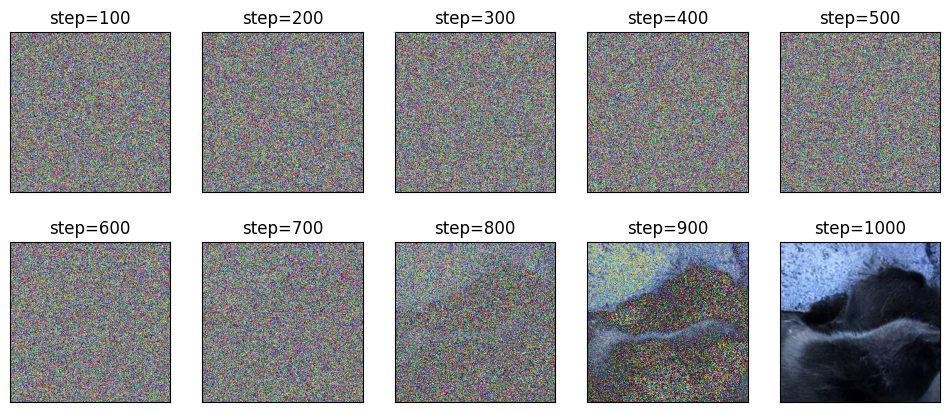

In [16]:
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
model.to(device)
noisy_sample = torch.randn(
    1,
    model.config.in_channels,
    model.config.sample_size,
    model.config.sample_size,
)
sample = noisy_sample.to(device)

scheduler = DDPMScheduler.from_pretrained(repo_id)
fig = plt.figure(figsize=(12, 5))

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. Predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. Compute less noisy image and set x_t -> x_t-1
    sample = scheduler.step(residual, t, sample).prev_sample

    # 3. Optionally look at image
    if (i + 1) % 100 == 0:
        display_sample(sample, i + 1, fig)
plt.show()

Получилось нечто котообразное.

## Обучение модели

Для обучения модели установим дополнительный пакет `diffusers[training]`.

In [17]:
!pip install -q diffusers[training]
clear_output()

### Конфигурация обучения

Параметры модели можно удобно упаковать в `dataclass` [🛠️[doc]](https://docs.python.org/3/library/dataclasses.html).



In [18]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 28  # the generated image resolution
    train_batch_size = 128
    eval_batch_size = 100  # how many images to sample during evaluation
    num_epochs = 10
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16"  # "no" for float32, "fp16" for automatic mixed precision
    output_dir = "ddpm-fmnist-28"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    seed = 42


config = TrainingConfig()

 Это удобно, т.к. этот тип объекта можно легко перевести в json и сохранить параметры обучения для данного эксперимента.

In [19]:
import dataclasses
import json

with open("train.json", "w") as f:
    json.dump(dataclasses.asdict(config), f)

### Создание модели

Denoising-модель можно легко создать, передав классу модели необходимые параметры:
- `sample_size` — высота и ширина изображения, тут 28×28.
- `in_channels`, `out_channels` — количество каналов изображения, тут 1 (черно-белое изображение).
- `down_block_types` и `up_block_types` — тип блоков понижения и повышения размерности, используемых для создания архитектуры U-Net. В данном случае у нас только по одному блоку с Attention ближе к середине U-Net:
 * `"DownBlock2D"` — это стандратный ResNet-блок,
 * `"AttnDownBlock2D"` — ResNet-блок с Attention.
- `block_out_channels` — количество выходных каналов блоков понижения размерности. Используется в обратном порядке для количества входных каналов блоков повышения размерности.
- `layers_per_block` — количество блоков ResNet, присутствующих в каждом блоке U-Net.


In [20]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per U-Net block
    block_out_channels=(
        32,
        64,
        128,
    ),  # the number of output channels for each U-Net block
    attention_head_dim=8,
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "UpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
    ),
)

Распечатаем архитектуру:

In [21]:
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

Проверим работоспособность модели и соответствие выхода модели входу:

In [22]:
sample_image = data_set[0][0].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 28, 28])


In [23]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 28, 28])


### Создание планировщика

In [24]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

Для $\large t$-го шага прямого диффузионного процесса зашумленное изображение $\large \mathbf{x}_t$ выражается через исходное изображение $\large \mathbf{x}_0$ следующим образом:

$$ \large \mathbf{x}_t = \sqrt{\overline{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \overline{\alpha}_t}\bar{\mathbf{n}}_{0}, $$

где $\large \bar{\alpha}_t = \prod_{s=1}^t \alpha_s$, а  $\large \bar{\mathbf{n}}_{0} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

Посмотрим, какие значения выдает планировщик:

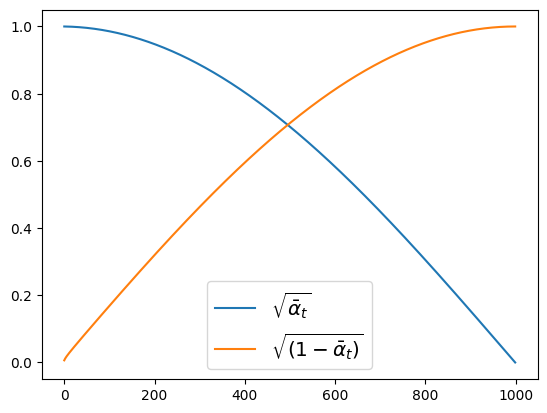

In [25]:
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")
plt.plot()
plt.show()

### Обучение

Denoising-модель предсказывает семпл нормального шума, добавленного к изображению. В качестве функции потерь используется MSE.

In [26]:
import torch.nn as nn

criterion = nn.MSELoss()
noise_pred = model(noisy_image, timesteps).sample
loss = criterion(noise_pred, noise)
print(f"{loss=}")

loss=tensor(1.2262, grad_fn=<MseLossBackward0>)


 Зададим оптимизатор и планировщик скорости обучения. Оптимизатор — Adam с weight decay. Планировщик скорости обучения — косинусный отжиг с прогревом.

In [27]:
from diffusers.optimization import get_cosine_schedule_with_warmup

train_dataloader = torch.utils.data.DataLoader(
    data_set, batch_size=config.train_batch_size, shuffle=True, num_workers=2
)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=len(train_dataloader),
    num_training_steps=2
    * (
        len(train_dataloader) * config.num_epochs
    ),  # del 2 for and increase config.num_epochs to increase value
)

Напишем код для генерации изображений для визуальной оценки во время обучения: код генерирует пачку изображений с помощью `pipeline` и сохраняет ее в `config.output_dir`:

In [28]:
import os
from diffusers.utils import make_image_grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        # Use a separate torch generator to avoid rewinding the random state of the main training loop
        generator=torch.Generator(device=device).manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=10, cols=10)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_grid)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

Напишем код для обучения модели на стандартном torch с использованием бибилиотеки Accelerate. В начале сценария обучения мы создаем экземпляр класса `Accelerator` [🛠️[doc]](https://huggingface.co/docs/accelerate/quicktour). Он инициализирует все необходимое для распределенного обучения и автоматически определяет среду обучения (CPU, машина с одним графическим процессором, машина с несколькими графическими процессорами, кластер и т. д.) в зависимости от того, с какими параметрами был запущен код.

При использовании `Accelerator` нам не нужно прописывать `.cuda()` или `to(device)` — это делается автоматически. В данном случае мы передаем модели:

- `mixed_precision` — у нас `"fp16"`, ускоряет вычисления за счет выполнения операций в формате половинной точности;
- `log_with` — логировать будем с помощью TensorBoard;
- `project_dir` — директория для логирования и сохранения контрольных точек.



Далее готовятся директории и репозиторий на `huggingface_hub`.

После этого мы передаем модель, оптимизатор, загрузчик данных и планировщик скорости в метод `Accelerator.prepare`. Этот метод производит оптимизацию кода с учетом доступной конфигурации устройства для распределения вычислений. Более подробно об этом можно почитать [тут 🛠️[doc]](https://huggingface.co/docs/accelerate/concept_guides/internal_mechanism).

Далее код мало отличается от привычного нам кода на torch.

In [29]:
import os
from pathlib import Path
from tqdm.auto import tqdm
from accelerate import Accelerator
from diffusers import DDPMPipeline
from huggingface_hub import create_repo, upload_folder


def train_loop(
    config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler
):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name,
                exist_ok=True,
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(
            total=len(train_dataloader), disable=not accelerator.is_local_main_process
        )
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (bs,),
                device=clean_images.device,
                dtype=torch.int64,
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = criterion(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(
                unet=accelerator.unwrap_model(model), scheduler=noise_scheduler
            )

            if (
                epoch + 1
            ) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (
                epoch + 1
            ) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

Можно запустить TensorBoard, чтобы можно было наблюдать за обучением.

In [30]:
# %load_ext tensorboard
# %tensorboard --logdir /content/ddpm-fmnist-28 --port 6006

Но мы в рамках лекции визуализируем логи TensorBoard с помощью [tbpars 🛠️[doc]](https://tbparse.readthedocs.io/en/latest/).

In [31]:
!pip install -q tbparse

In [32]:
from tbparse import SummaryReader


def visual_log(log_dir):
    # Visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars.drop_duplicates()

    uniq = set(df.tag.unique())
    uniq.remove("step")
    uniq = list(uniq)
    uniq.sort()

    i = 0
    ax_dict = {}
    for item in uniq:
        metric = item.split("/")[0]
        if metric not in ax_dict:
            ax_dict[metric] = i
            i += 1

    fig, axs = plt.subplots(len(ax_dict), 1, figsize=(12, 3.5 * len(ax_dict)))
    for item in uniq:
        metric = item.split("/")[0]
        ax = axs[ax_dict[metric]]
        sub_df = df[df["tag"] == item]
        ax.plot(sub_df.step, sub_df.value, label=item)
        ax.set_ylabel(metric)
        ax.legend()
        ax.set_xlabel("iter")
        if item == "loss":
            ax.set_yscale("log")
    plt.show()

Теперь мы соберем в `args` аргументы `train_loop`. Обучение будем проводить с помощью фукции `notebook_launcher` [🛠️[doc]](https://huggingface.co/docs/accelerate/v0.11.0/en/launcher) — это функция для запуска распределенного обучения в блокноте. Здесь функция закомментирована для ускорения работы блокнота.

In [33]:
from accelerate import notebook_launcher


args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
# notebook_launcher(train_loop, args, num_processes=1) # train

Загрузим логи модели, посмотрим на результат генерации.

In [34]:
!wget -q https://ml.gan4x4.ru/msu/dev-2.4/L13/weights/ddpm_fmnist_28.zip
!unzip -qq /content/ddpm_fmnist_28.zip

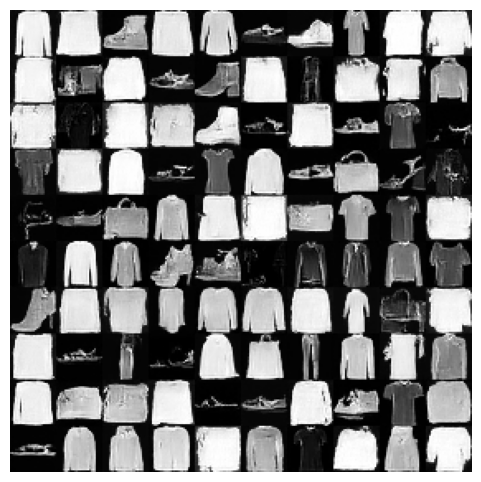

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(6, 6))
image = mpimg.imread(f"{config.output_dir}/samples/{config.num_epochs-1:04d}.png")
plt.imshow(image)
plt.axis("off")
plt.show()

Получилось вполне похоже (для получения лучшего качества нужно увеличить количество эпох и слоев). Посмотрим на логи обучения, в ходе обучения использовался планировщик скорости обучения с warm up и косинусным уменьшением скорости (только половина косинуса).

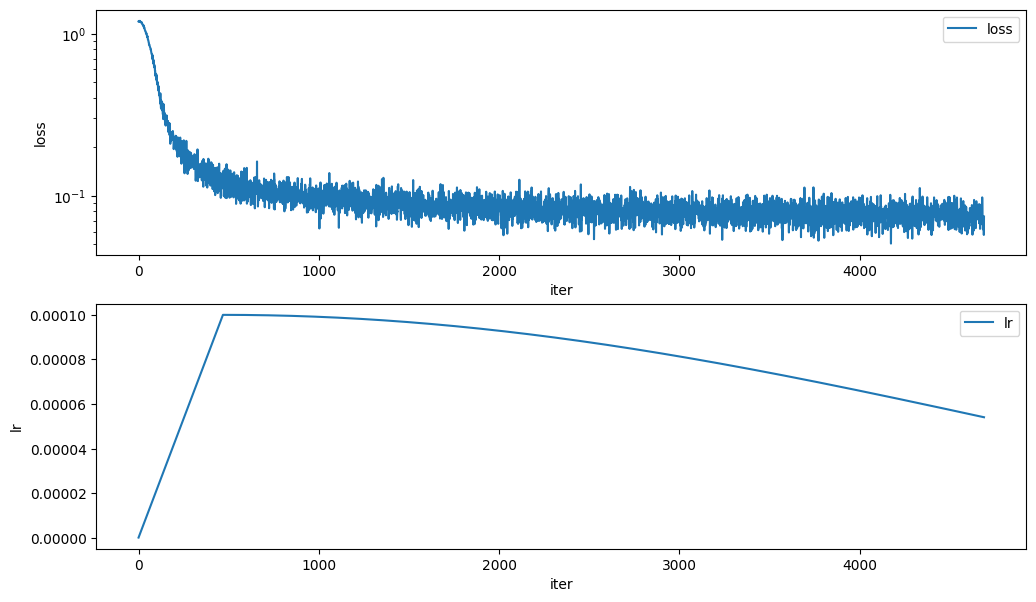

In [36]:
visual_log(config.output_dir)

Мы обучили свою первую диффузионную модель с помощью библиотеки Diffusers.

## Solver

Вы наверняка заметили, что генерация в 1000 шагов с использованием DDPMScheduler — это **долго**, т.к. **модель запускается 1000 раз**. Сокращение количества шагов — одно из направлений развития диффузионных моделей.

Работая с диффузионными моделями, вы встретитесь с таким понятием, как solver (решатель). В рамках лекции невозможно разобрать всю математику, лежащую за этим понятием, но мы попробуем дать интуицию, что такое solver и что он решает.

Мы описывали шаг прямого диффузионного процесса как:

$$\large \mathbf{x_t} = \sqrt{1-\beta_t}\mathbf{x_{t-1}}+\sqrt{\beta_t}\mathbf{n_{t-1}}$$

Мы можем разложить $\sqrt{1-\beta_t}$ в [ряд Тейлора 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A0%D1%8F%D0%B4_%D0%A2%D0%B5%D0%B9%D0%BB%D0%BE%D1%80%D0%B0). Тогда мы получим [разностную схему 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%81%D1%85%D0%B5%D0%BC%D0%B0):

$$\large \mathbf{x_t} - \mathbf{x_{t-1}}= - \frac{\mathbf{x_{t-1}}}{2}d\beta+n_{\beta} \sqrt{d\beta}$$
Мы можем перейти к непрерывному времени и получить [стохастическое дифференциальное уравнение 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B4%D0%B8%D1%84%D1%84%D0%B5%D1%80%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%83%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5) (СДУ, Stochastic differential equation, SDE) :

$$\large d\mathbf{x} = - \frac{\mathbf{x}}{2}d\beta+n_{\beta} \sqrt{d\beta},$$

которое является уравнением диффузии.




Этот переход важен, потому что:
1. Он объясняет, почему диффузионные модели называются диффузионными.
2. Для уравнения диффузии можно перейти от семплирования из распределения в вероятностную постановку и заменить стохастическое дифференциальное уравнение [обыкновенным 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%8B%D0%BA%D0%BD%D0%BE%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B8%D1%84%D1%84%D0%B5%D1%80%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%83%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5) (ОДУ, Ordinary differential equation, ODE). А ОДУ можно обратить по времени и эффективно решить [численными методами 📚[wiki]](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations).


Разберемся, что это дает для модели диффузии: при генерации изображения можно не удалять “весь шум”, семплировать и добавлять новый, а модифицировать старый шум, двигаясь по более гладкой и более предсказуемой траектории (двигаться вместо красных линий по белым, см. картинку).


<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/sde_vs_ode.png" width="550"></center>

<center><em>Сравнение траектории обратного диффузионного процесса для СДУ (SDE, красные траектории) и ОДУ (ODE, белые траектории)</a></em></center>

<center><em>Source: <a href="https://arxiv.org/html/2401.09050v1">Consistent3D: Towards Consistent High-Fidelity Text-to-3D Generation with Deterministic Sampling Prior</a></em></center>




Т.к. траектория получается **более гладкой**, можно использовать **меньшее количество шагов для генерации**. Для движения по траектории необходимо решать ОДУ, для этого используются ODE solver-ы (решатели). Они используют численные методы решения ОДУ, такие как [метод Эйлера 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%AD%D0%B9%D0%BB%D0%B5%D1%80%D0%B0), [метод Рунге — Кутты 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%A0%D1%83%D0%BD%D0%B3%D0%B5_%E2%80%94_%D0%9A%D1%83%D1%82%D1%82%D1%8B) и т.д.,  для оценки белой траектории за небольшое количество шагов.

Для понимания математики советуем:
* [[video] 📺 Интенсив по CV от ШАД (лекция 2)](https://shad.yandex.ru/cvweek#program)

Примеры реализованных вариантов решателей:
* [[git] 🐾 ResShift: Efficient Diffusion Model for Image Super-resolution by Residual Shifting](https://github.com/zsyOAOA/ResShift/tree/journal?tab=readme-ov-file)
* [[git] 🐾 SinSR: Diffusion-Based Image Super-Resolution in a Single Step](https://github.com/wyf0912/SinSR/tree/main)


## Диффузия в латентном пространстве

Как мы упомянули выше, попиксельный Self-Attention — вычислительно тяжелый слой. В 2022 году вышла [статья 🎓[arxiv]](https://arxiv.org/pdf/2112.10752.pdf), предлагающая объединение VAE и DM для создания изображений высокого разрешения.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/latent_diffusion_architecture.png" width="800"></center>

<center><em>Архитектура модели диффузии в латентном пространстве</a></em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2112.10752.pdf">High-Resolution Image Synthesis with Latent Diffusion Models</a></em></center>

Отметим некоторые особенности архитектуры:
- в архитектуре используется заранее предобученный на большом массиве данных VAE, что позволяет генерировать картинки большого размера,
- “зашумление” и “расшумление” происходят в латентном пространстве,
- помимо позиционного эмбеддинга при изменении размерности могут “подмешиваться” номера классов, эмбеддинги текстов или изображений, эмбеддинги семантических масок, карты глубины, скетчи, контуры объектов и т. д. “Подмешивание” может осуществляться через cross-attention.


## Каскадная диффузия

Альтернативой диффузии в латентном пространстве является каскадная диффузия. Идея — генерировать изображение в несколько шагов с применением Super-Resolution для уменьшения размера модели:
- Текстовая модель — нужно брать побольше, т.к. качество embedding-а критически влияет на результат Text2Image генерации.
- Базовая модель $\sim1B$ параметров, 20–50 шагов. Вход: зашумленное изображение, текстовый embedding.
- Super-Resolution модель $\sim400M$ параметров, 10–20 шагов. Вход: конкатенация (зашумленное изображение, интерполированное изображение в меньшем разрешении), текстовый embedding.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/cascade_diffusion.jpg" width="600"></center>

<center><em>Визуализация Imagen. Imagen использует большой замороженный кодер T5-XXL для кодирования входного текста во вложения. Условная диффузионная модель отображает вложение текста в изображение 64×64. Imagen далее использует текстово-условные модели диффузии сверхвысокого разрешения для повышения разрешения изображения 64×64→256×256 и 256×256→1024×1024.</em></center>

<center><em>Source: <a href="https://imagen.research.google/">Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding</a></em></center>

## ControlNet

Проблемой **Text2Image** моделей является то, что они **ограничены в контроле над пространственной композицией изображения**. Точное воспроизведение поз, фигур, форм по текстовому описанию — сложная задача.
Рассмотрим идею, которая делает генерацию более управляемой за счет добавления изображений с информацией о композиции. Это могут быть границы объектов, позы человека, маски глубины и т.д.


<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/control_net.png" width="800"></center>

<center><em>Пример управляемой генерации ControlNet
</a></em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2302.05543">Adding Conditional Control to Text-to-Image Diffusion Models</a></em></center>


Для решения этой задачи существует архитектура ControlNet. Она является надстройкой над предварительно обученной и замороженной диффузионной моделью.

Создается обучаемая копия encoder-блоков модели, в которые копируются веса исходной модели (голубые блоки на картинке). Эти блоки окружаются "нулевыми" сверточными слоями — 1×1 сверточными слоями, в которых веса и смещения изначально инициализированы нулями. Так ControlNet до обучения вносит нулевой вклад. Также "нулевые" сверточные слои не дают "сломать" предобученные копии блоков в начале обучения. В процессе обучения вклад ControlNet в генерацию увеличивается.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L13/stable_diffusion_vs_controlnet.png" width="415"></center>

<center><em>Архитектура U-net Stable Diffusion, соединенная
с ControlNet. Обучаются синие блоки и zero convolution
</a></em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2302.05543">Adding Conditional Control to Text-to-Image Diffusion Models</a></em></center>


Про распространение градиента в "нулевых" свертках:
* [[article] 🎓 Adding Conditional Control to Text-to-Image
Diffusion Models](https://lllyasviel.github.io/misc/202309/cnet_supp.pdf)

Реализация:
* [[git] 🐾 Репозиторий ControlNet с инструкцией по запуску](https://github.com/lllyasviel/ControlNet)
* [[git] 🐾 Web-интерфейс для ControlNet](https://github.com/Mikubill/sd-webui-controlnet)

## Конвейеры

В библиотеке 🧨 Diffusers есть 3 основные идеи/части :

 - [[doc] 🛠️ Планировщики](huggingface.co/docs/diffusers/api/schedulers/overview) — алгоритмы, контролирующие добавление и вычитание шума.

 Назначение: добавление шума при обучении и добавление и вычитание шума при генерации.

 - [[doc] 🛠️ Модели](https://huggingface.co/docs/diffusers/main/en/api/models) — предварительно обученные модели для популярных алгоритмов и модули для создания моделей диффузии.

 Назначение: строительные блоки для диффузионных систем.

 - [[doc] 🛠️ Конвейеры](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) — высокоуровневый класс для генерации объектов с помощью предварительно обученных моделей диффузии.

 Назначение: запуск модели с 4-х строк кода.

C планировщиками и моделями мы уже познакомились. Теперь взглянем, как взаимодействовать с конвейером `DiffusionPipeline`.



В рамках лекции попробуем запустить Pipeline диффузии в латентном пространстве.

In [37]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Pipeline — это быстрый и простой способ запустить модель для вывода, требующий не более четырех строк кода для создания изображения. Загрузим `pipeline` для модели `stable-diffusion-v1-5`.

In [38]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", use_safetensors=True
)

clear_output()

`DiffusionPipeline` загружает и кэширует все компоненты модели, токенизации и планирования. Можем посмотреть, что в `StableDiffusionPipeline` [🛠️[doc]](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/overview) входят:
- [[doc] 🛠️](https://huggingface.co/docs/diffusers/v0.28.0/en/api/models/unet2d-cond#diffusers.UNet2DConditionModel) `UNet2DConditionModel` — условная 2D-модель U-Net в качестве denoising-модели.
- [[doc] 🛠️](https://huggingface.co/docs/diffusers/api/models/autoencoderkl) `AutoencoderKL` — вариационный автоэнкодер. Stable Diffusion подразумевает диффузию в латентном пространстве.
- [[doc] 🛠️](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm) `PNDMScheduler` — solver, использует метод Рунге — Кутты. В 20 раз эффективнее базового `DDPMScheduler` [🛠️[doc]](https://huggingface.co/docs/diffusers/v0.28.0/en/api/schedulers/ddpm). Подробности в [статье 🎓[arxiv]](https://arxiv.org/pdf/2202.09778).
- Для условной генерации используется [CLIP 🛠️[doc]](https://huggingface.co/docs/transformers/model_doc/clip) из библиотеки 🤗 Transformers.

In [39]:
print(pipeline)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



  0%|          | 0/50 [00:00<?, ?it/s]

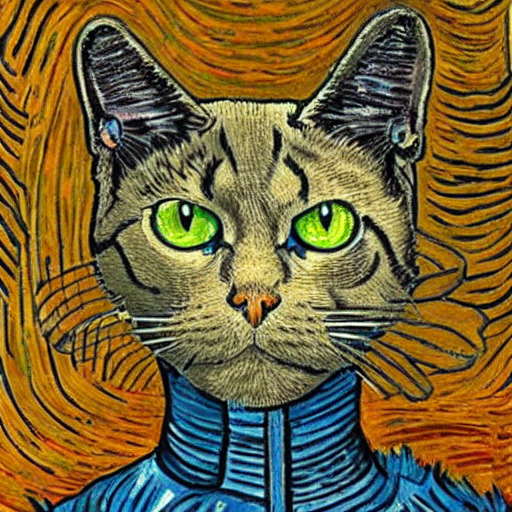

In [40]:
torch.manual_seed(42)

pipeline.to(device)

image = pipeline("An image of a cybernetic cat in van Gogh style").images[0]
image

Более подробную полную информацию по работе с диффузией в латентном пространстве ищите в [документации 🛠️[doc]](https://huggingface.co/docs/diffusers/index).

[[video] 📺 Интенсив по моделям для генерации от ШАД Yandex](https://shad.yandex.ru/cvweek#program)